In [ ]:
import torch
print(torch.__version__)

In [28]:
! hostname
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np

a00551.science.domain


In [29]:
# import the python scripts in this folder
import sys
sys.path.append("./erda/deep_contact")
from unet_model import UNet
from hdf5_dataset import SimulationHdf5Dataset

In [30]:
from pathlib import Path
# we pull the dataset onto local storage if it's not there:
SIMDATA='erda/data/2dsim/xml1515100_res0.125_h0.5.hdf5'
SIMDATA_tmp='/tmp/xml1515100_res0.125_h0.5.hdf5'

if not Path(SIMDATA_tmp).exists():
    !cp  $SIMDATA $SIMDATA_tmp

In [31]:
# define some constants
PATH = Path('erda/data/2dsim')
# batch size
bs=64

In [32]:
import pickle
# load dataset statistics
ds = SimulationHdf5Dataset(SIMDATA_tmp)
SIMDATA_stats = SIMDATA + '_stats.pkl'
with open(SIMDATA_stats, 'rb') as f:
    stats = pickle.load(f)
stats

{'X_mean': array([ 0.00536,  0.00067, -0.00024, -0.01445, -0.00012,  0.00027], dtype=float32),
 'X_std': array([0.01276, 0.00159, 0.01406, 0.06313, 0.01683, 0.03144], dtype=float32),
 'Y_mean': array([0.00007, 0.00071, 0.0042 , 0.00001], dtype=float32),
 'Y_std': array([0.01149, 0.01338, 0.02493, 0.00592], dtype=float32)}

In [33]:
# train-validation-test split
SIMDATA_split = SIMDATA + '_splits.pkl'
with open(SIMDATA_split, 'rb') as f:
    split = pickle.load(f)
len(ds),[s.shape for s in split.values()]

(13822, [(10174,), (2543,), (1105,)])

In [34]:

# reverse the index of the dataset
body_channels = {k: v for k, v in zip(ds.body_channels,range(len(ds.body_channels)))}
contact_channels = {k: v for k, v in zip(ds.contact_channels,range(len(ds.contact_channels)))}


from fastai.conv_learner import *

# we're not training anymore, so we don't need any data loaders
md = ModelData(path=PATH,trn_dl=None, val_dl=None, test_dl=None)

## choose the neural network we are testing

In [35]:
b_idxs = [body_channels['mass'],
          body_channels['inertia'],
          body_channels['vx'],
          body_channels['vy'],
          body_channels['omega']]
# what are we trying to predict?
c_idxs = [contact_channels['ni'],
          contact_channels['ti']]

def get_data(ds,i):
    X=ds[i][0][b_idxs]
    Y=ds[i][1][c_idxs]
    return X, Y

X_mean = stats['X_mean'][b_idxs]
X_std = stats['X_std'][b_idxs]
Y_mean = stats['Y_mean'][c_idxs]
Y_std = stats['Y_std'][c_idxs]

net = UNet(5,2)
learn = Learner.from_model_data(m=net, data=md)
learn.load("3mar_20epochs_final")

In [10]:
b_idxs = [body_channels['mass'],
          body_channels['inertia'],
          body_channels['vx'],
          body_channels['vy'],
          body_channels['omega']],
c_idxs = [contact_channels['ni'],
          contact_channels['ti']]

def get_data(ds,i):

    Y_prev = ds[i-1][1][c_idxs]
    X=ds[i][0][b_idxs]
    
    X=np.concatenate([X,Y_prev])
    Y=ds[i][1][c_idxs]
    return X,Y

X_mean = np.concatenate([stats['X_mean'][b_idxs],stats['Y_mean'][c_idxs]])
X_std = np.concatenate([stats['X_std'][b_idxs],stats['Y_std'][c_idxs]])
Y_mean = stats['Y_mean'][c_idxs]
Y_std = stats['Y_std'][c_idxs]

net = UNet(7,2)
learn = Learner.from_model_data(m=net, data=md)
learn.load("4mar_temporal_20epochs_final")

In [36]:
from torchvision.transforms import *
from fastai.dataset import *

class Tensorize(object):
    def __call__(self, pic):
        return torch.from_numpy(pic).float()

    def __repr__(self):
        return self.__class__.__name__ + '()'

class PadToSize(object):
    def __call__(self,pic):
        return np.pad(pic,((0,0),(3,4),(3,4)),'constant')
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

class Norm(object):
    def __init__(self,mean,std):
        self.mean=mean
        self.std=std
        
    def __call__(self,pic):
        pic = (np.moveaxis(pic, 0, -1) - self.mean)/self.std
        return np.moveaxis(pic, -1, 0)
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

class UnPad(object):
    def __call__(self,pic):
#         import pdb; pdb.set_trace()
        return pic[:,3:-4,3:-4]
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

class DeNorm(object):
    def __init__(self,mean,std):
        self.mean=mean
        self.std=std
        
    def __call__(self,pic):
#         import pdb; pdb.set_trace()
        pic = np.moveaxis(pic, 0, -1) * self.std + self.mean
        return np.moveaxis(pic, -1, 0)
    
    def __repr__(self):
        return self.__class__.__name__ + '()'

class DeepContactDataset(Dataset):
    def __init__(self):
        self.tensorize=Tensorize()
        self.pad = PadToSize()
        self.norm_x = Norm(mean=X_mean, std=X_std)
        self.norm_y= Norm(mean=Y_mean, std=Y_std)
        self.denorm_y = DeNorm(mean=Y_mean, std=Y_std)
        self.unpad = UnPad()
    
    def __getitem__(self, index):
        X,Y=get_data(ds, index);
        X=self.pad(X)
        X=self.norm_x(X)
        X=self.tensorize(X)
        
        Y=self.pad(Y)
        Y=self.norm_y(Y)
        Y=self.tensorize(Y)
        
        return X,Y

    def __len__(self):
        return len(ds)

## Check how good the predictions are

In [19]:
from torch.utils.data.dataset import Subset
dcds = DeepContactDataset()
# dcds = Subset(dcds,split['test_idxs'])


In [20]:
# def predict(ds : DeepContactDataset, i):
def predict(X, Y):
    learn.model.eval()
#     import pdb; pdb.set_trace()
    X = X[None,:,:,:] # create single-element batch
    Y_hat =learn.model(V(X))
    Y_hat = Y_hat.squeeze(0) # get rid of the batch
    Y_hat = Y_hat.cpu().data.numpy()
    Y_hat = dcds.unpad(Y_hat)
    Y_hat = dcds.denorm_y(Y_hat)

    Y = Y.numpy()
    Y = dcds.unpad(Y)
    Y = dcds.denorm_y(Y)
    return Y_hat, Y

In [21]:

def show_colormap(I, zoom_in=False):
    I=np.flip(I)
    if zoom_in:
        plt.imshow(I,cmap='seismic')
    else:
        plt.imshow(I,cmap='seismic',vmin=-1,vmax=1)
    plt.colorbar()

In [22]:
i = np.random.choice(split['test_idxs'])
X,Y=dcds[i]
Y_hat, Y = predict(X,Y)
# what is the range ? 
'i',i,\
'mins',np.min(Y_hat[0,:,:]),np.min(Y_hat[1,:,:]),\
'maxes',np.max(Y[0,:,:]),np.max(Y[1,:,:])

('i', 4793, 'mins', -0.005342272, -0.25289544, 'maxes', 1.5261106, 0.30884537)

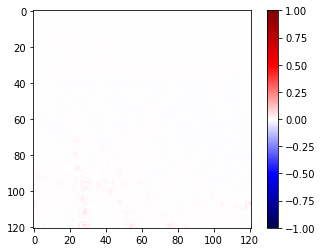

In [23]:
show_colormap(Y_hat[0,:,:]-Y[0,:,:],zoom_in=False)

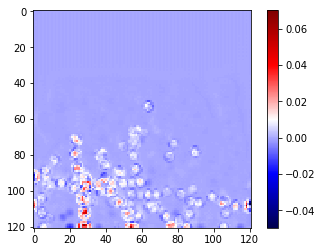

In [24]:
show_colormap(Y_hat[0,:,:]-Y[0,:,:],zoom_in=True)

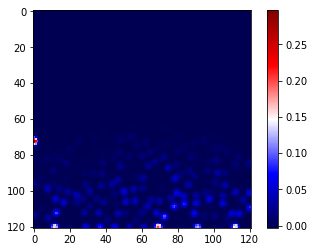

In [19]:
show_colormap(Y_hat[0,:,:],zoom_in=True)

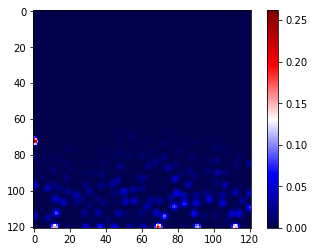

In [20]:
show_colormap(Y[0,:,:],zoom_in=True)

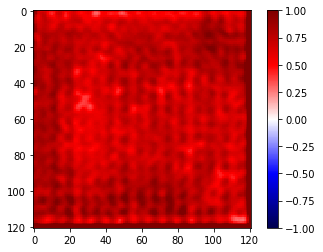

In [21]:
# This seems too good to be true ! Let's see how the NN works with a random 5D tensor.
X_random = torch.FloatTensor(np.random.rand(X.shape[0],128,128))
Y_random = torch.FloatTensor(np.random.rand(2,128,128))

Y_hat_r, Y_r = predict(X_random,Y_random)
# show_colormap(Y_hat_r[0,:,:])
# show_colormap(Y_r[0,:,:])
show_colormap(Y_hat_r[0,:,:]-Y_r[0,:,:])

### Time to use the simulator and get some convergence plots

In [37]:
from Box2D import b2World
from run_sim import RunSimParams, run_simulation
from gen_world import new_confined_clustered_circles_world
from warmstart_models import BuiltinWarmStartModel
from sim_types import SimData

In [38]:
# Number of bodies in worlds
nBodies = 100
# Something about spread of bodies?
sigma_coef = 1.2
# Dimension of static box
xlow, xhi = 0, 15
ylow, yhi = 0, 15
p_ll = (xlow, ylow)
p_hr = (xhi, yhi)

# body radius min and max
radius = (0.5, 0.5)

# grid parameters
xRes, yRes = (0.125,0.125)
h = 0.5

# Timestep
timeStep = 1.0 / 100
# Iteration limits
velocityIterations = 1000
positionIterations = 250
# Iteration thresholds
velocityThreshold = 1e-4
positionThreshold = 1e-4

PATH=Path('erda/deep_contact/test_gen_data')

In [40]:
from warmstart_models import Model,CustomContactListener,copyWorld
from sph_grid import Grid, dataframe_to_grid
from dataframes import dataframes_from_b2World

# Our CNN model
class UNetModel(Model):
    def __init__(self):
        super(UNetModel, self).__init__()
        
        self.body_channels = ['mass','inertia','vx','vy','omega']
        self.contact_channels = ['ni','ti']
        self.ContactListener = CustomContactListener()
        self.dcds = DeepContactDataset()
        # We create the grid manager
        self.G = Grid((xlow,ylow),(xhi,yhi),(xRes,yRes))


    def Step(self, world, timeStep, velocityIterations, positionIterations):
        super(UNetModel, self).Step(
            world, timeStep, velocityIterations, positionIterations
        )

        # Reset
        self.ContactListener.reset()

        # We create the body dataframes for the current world
        df_b, _ = dataframes_from_b2World(world)

        # We create a copy of our world, and ask it to take a step
        # This is done in order to obtain all contact information, including
        # contacts that might only appear during the step
        copy = copyWorld(world)
        copy.contactListener = self.ContactListener

        copy.Step(timeStep, velocityIterations, positionIterations)

        df_c = self.ContactListener.df_c
        N = df_c.shape[0]
        if N == 0:
            return

        # We create the grids
        b_grids=[]
        for c in self.body_channels:
            b_grids.append(dataframe_to_grid(G=self.G,channel=c,df=df_b,support_radius=h))
        b_grids = np.array(b_grids)
        
        #use the CNN to make a prediction
        b_grids = self.dcds.pad(b_grids)
        b_grids=self.dcds.norm_x(b_grids)
        b_grids=self.dcds.tensorize(b_grids)
        Y_hat,_ = predict(b_grids,torch.FloatTensor(np.random.rand(2,128,128)))
        Y_hat = np.flip(Y_hat)

        c_grids={}
        for n,g in zip(self.contact_channels,Y_hat):
            c_grids[n]=g
            
        c_pos = [(i,j) for i,j in zip(df_c.px.values,df_c.py.values)]
        c_preds={}
        for c in self.contact_channels:
            c_preds[c]=self.G.collect(c_grids[c],c_pos)

        
        # We store the results for easy acces
        for i in range(N):
            row = df_c.loc[i]
            master = int(row['master'])
            slave = int(row['slave'])
            key = (master, slave)

            px = row['px']
            py = row['py']

#             import pdb; pdb.set_trace()
            prediction = [px, py] + [c_preds['ni'][i],c_preds['ti'][i]]
            
            if key in self.predictionDict:
                self.predictionDict[key].append(prediction)
            else:
                self.predictionDict[key] = [prediction]


    # Set impulses based on stored predictions
    def PreSolve(self, contact, old):
        super(UNetModel, self).PreSolve(contact, old)


    # Store impulse predictions and results for error calculations
    def PostSolve(self, contact, impulse):
        super(UNetModel, self).PostSolve(contact, impulse)


## Run lots of simulations to get the final results

In [41]:
from warmstart_models import NoWarmStartModel, BuiltinWarmStartModel, BadModel, \
RandomModel, CopyWorldModel, IdentityGridModel

models = []
models.append((NoWarmStartModel(),'none'))
models.append((BuiltinWarmStartModel(),'builtin'))
models.append((BadModel(),'bad'))
# seed is None, fully random warmstarts
models.append((RandomModel(None),'random'))
# copy world with no rounding, 2 decimals and 0 decimals
models.append((CopyWorldModel(),'copy'))
models.append((CopyWorldModel(2),'copy2'))
models.append((CopyWorldModel(0),'copy0'))
models.append((IdentityGridModel(p_ll,p_hr,xRes=0.125,yRes=0.125,h=0.5),'grid'))
models.append((UNetModel(),'UNet'))

In [34]:
from Box2D import b2World,b2Vec2


num_worlds_per_model = 30
#seeds are completely random to reduce bias
seeds = random.sample(list(range(1,1000)),k=num_worlds_per_model)
# seeds = range(num_worlds_per_model)
sim_params = RunSimParams(
    steps = 250,
    velocityIterations = velocityIterations,
    positionIterations = positionIterations,
    timeStep = timeStep,
    p_hr = p_hr,
    p_ll = p_ll
)

for (m,n) in models:
    print("Running simulations for model ",n," ...")
    for i in range(num_worlds_per_model):
        print("World ",i+1," out of ",num_worlds_per_model," ...")
        # Create world
        world = b2World()
        world.userData = SimData(
            name=f"{n}_{i}",
            d_t=timeStep,
            vel_iter=velocityIterations,
            pos_iter=positionIterations,
            vel_thres=velocityThreshold,
            pos_thres=positionThreshold
        )

        # Fill world with static box and circles
        new_confined_clustered_circles_world(
            world,
            nBodies,
            b2Vec2(xlow, ylow),
            b2Vec2(xhi, yhi),
            radius,
            sigma_coef,
            seed=i
        ) # setting the seed makes sure we are solving the *SAME* simulation with every model

        # Set iteration thresholds
        world.velocityThreshold = velocityThreshold
        world.positionThreshold = positionThreshold
        run_simulation(world,sim_params,PATH, verbose=False,write_xml=False,
                       write_png=False, write_profile=True,model=m)
seeds

Running simulations for model  none  ...
World  1  out of  30  ...
World  2  out of  30  ...
World  3  out of  30  ...
World  4  out of  30  ...
World  5  out of  30  ...
World  6  out of  30  ...
World  7  out of  30  ...
World  8  out of  30  ...
World  9  out of  30  ...
World  10  out of  30  ...
World  11  out of  30  ...
World  12  out of  30  ...
World  13  out of  30  ...
World  14  out of  30  ...
World  15  out of  30  ...
World  16  out of  30  ...
World  17  out of  30  ...
World  18  out of  30  ...
World  19  out of  30  ...
World  20  out of  30  ...
World  21  out of  30  ...
World  22  out of  30  ...
World  23  out of  30  ...
World  24  out of  30  ...
World  25  out of  30  ...
World  26  out of  30  ...
World  27  out of  30  ...
World  28  out of  30  ...
World  29  out of  30  ...
World  30  out of  30  ...
Running simulations for model  builtin  ...
World  1  out of  30  ...
World  2  out of  30  ...
World  3  out of  30  ...
World  4  out of  30  ...
World  5  

[334,
 348,
 377,
 702,
 586,
 497,
 615,
 518,
 407,
 933,
 470,
 331,
 946,
 982,
 641,
 593,
 932,
 484,
 380,
 990,
 843,
 995,
 789,
 432,
 117,
 746,
 270,
 844,
 485,
 999]

In [42]:
profile_data = {}
for (_,n) in models:
    profile_fils = sorted(list(PATH.glob(f"{n}_*.npz")))
    profile_data[n]=[]
    for f in profile_fils:
        print("Loading profile data from ", f, ' ...')
        profile_data[n].append(np.load(f)['results'].tolist())
profile_data.keys(), len(profile_data['none'])

Loading profile data from  erda/deep_contact/test_gen_data/none_0_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_10_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_11_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_12_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_13_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_14_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_15_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_16_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_17_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_18_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/none_19_000000-000249.npz  ...
Loading pro

Loading profile data from  erda/deep_contact/test_gen_data/random_10_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_11_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_12_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_13_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_14_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_15_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_16_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_17_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_18_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_19_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/random_1_000000-00024

Loading profile data from  erda/deep_contact/test_gen_data/copy0_11_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_12_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_13_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_14_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_15_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_16_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_17_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_18_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_19_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_1_000000-000249.npz  ...
Loading profile data from  erda/deep_contact/test_gen_data/copy0_20_000000-000249.npz  ...


(dict_keys(['none', 'builtin', 'bad', 'random', 'copy', 'copy2', 'copy0', 'grid', 'UNet']),
 30)

In [43]:
from warmstart_plot import preprocess_profiles, show_iterations_plot, show_velocity_convergence,\
show_position_convergence, show_lambda_errors,smooth

to_plot={}
for m in profile_data.keys():
    to_plot[m] = preprocess_profiles(profile_data[m],velocityIterations,positionIterations)
    
colors = {'none':'cyan','grid':'orange',
          'bad':'magenta','UNet':'green',
          'copy0':'blue','builtin':'red',
          'copy':'black','copy2':'indigo','random':'brown'}

/home/hrn947/.pyenv/versions/3.6.6/envs/oldfastai/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/hrn947/.pyenv/versions/3.6.6/envs/oldfastai/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


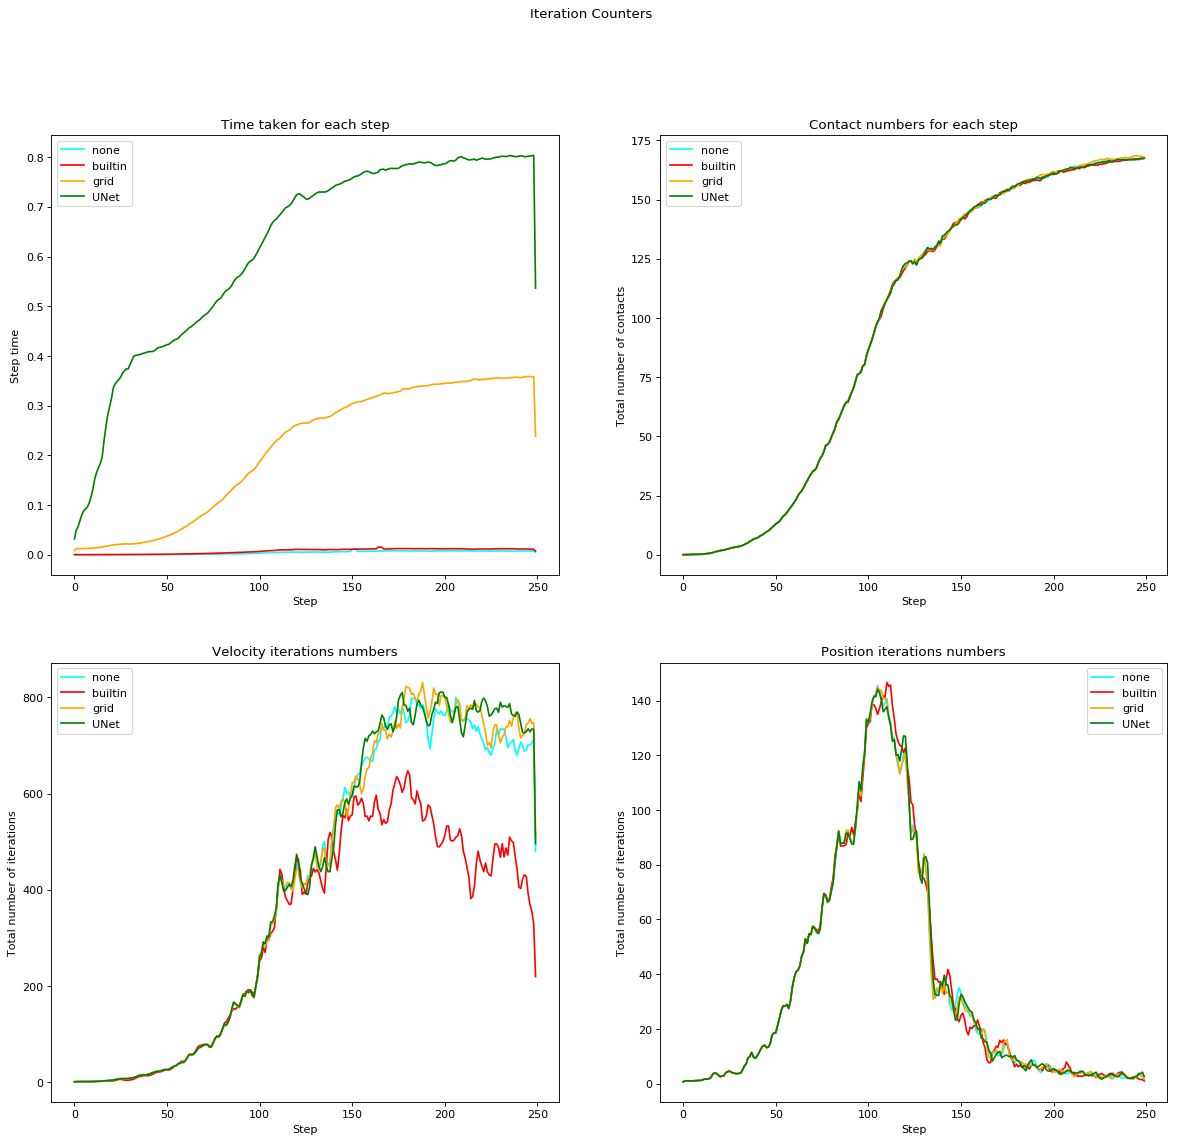

In [47]:
# Iteration plots Smoothing factor - set to 1 to turn off smoothing
show_iterations_plot(to_plot,colors,smoothingFactor=3, skip_plots=['copy','copy0','copy2','bad','random'])

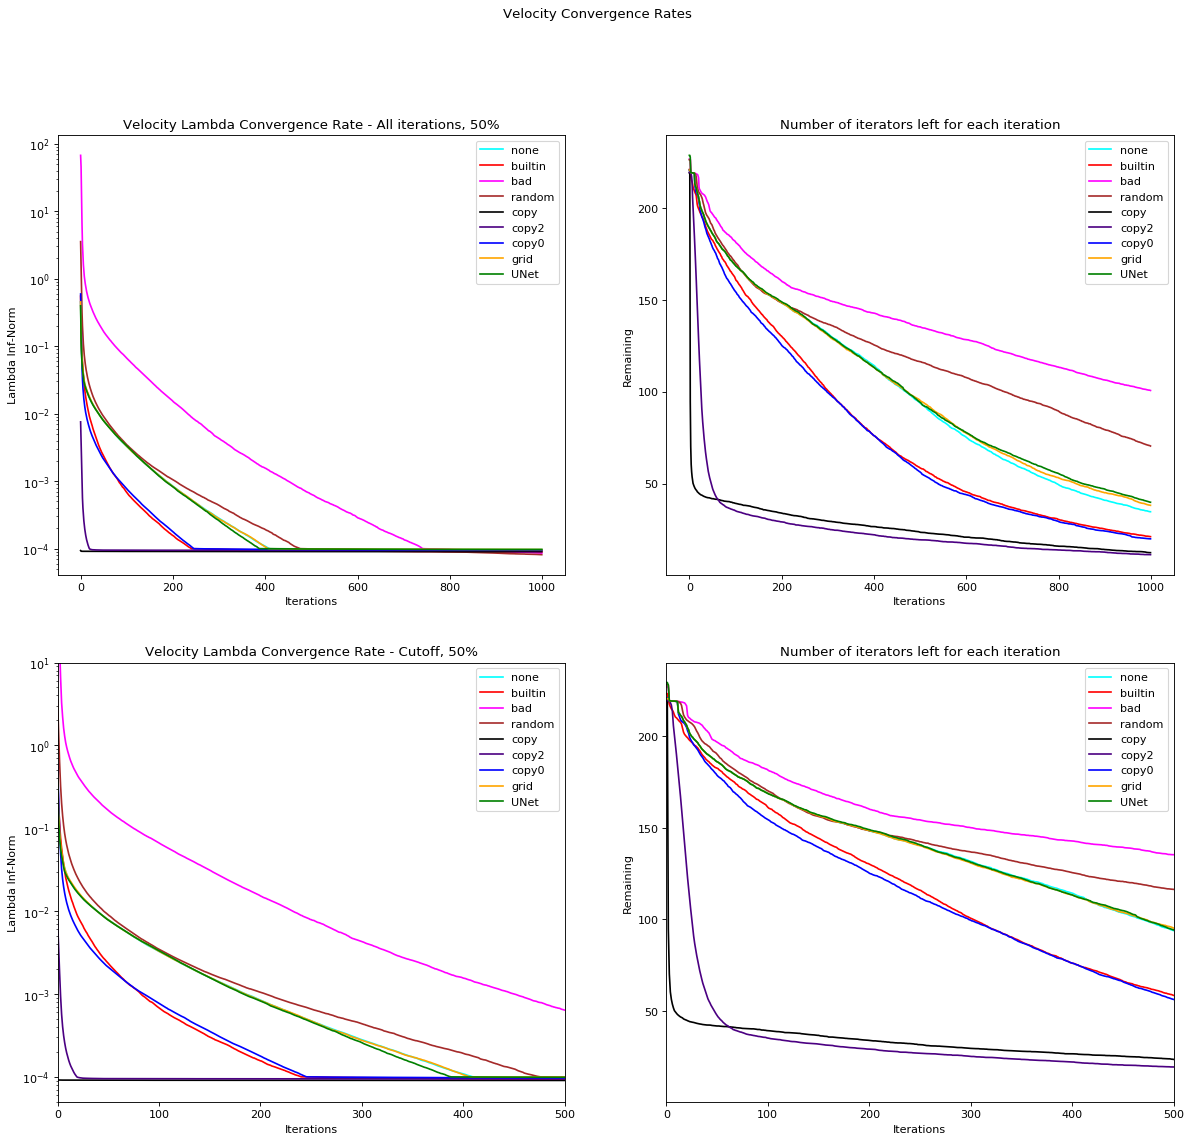

In [38]:
show_velocity_convergence(to_plot,colors, velocityThreshold)

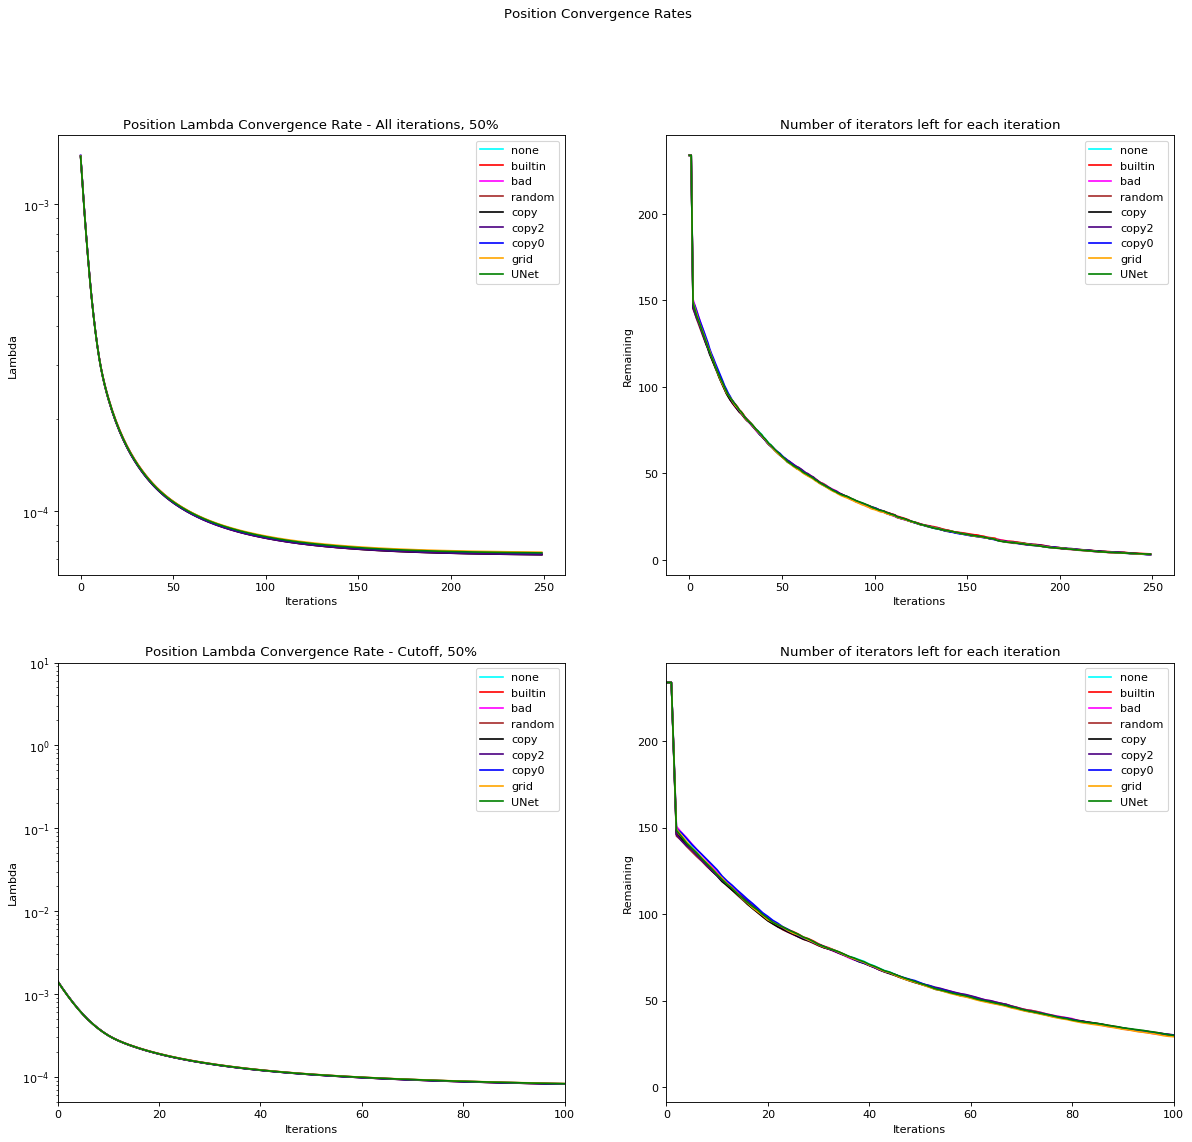

In [39]:
show_position_convergence(to_plot,colors,positionThreshold)

./erda/deep_contact/warmstart_plot.py:325: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax1.set_title("Tangent Impulse Errors")
./erda/deep_contact/warmstart_plot.py:337: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Function for smoothing data using a moving average as far as I recall


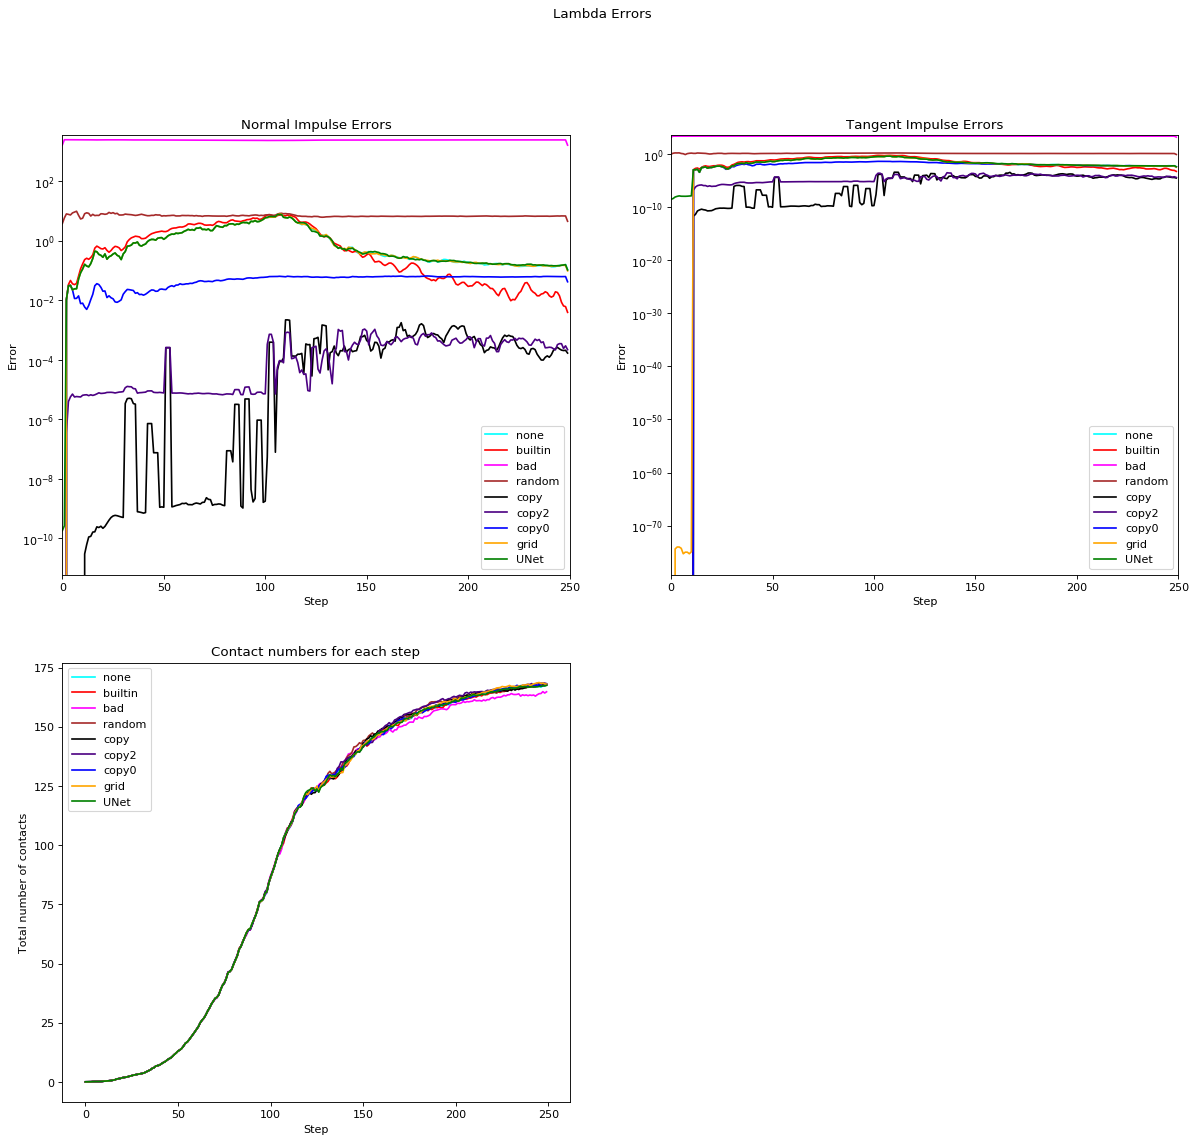

In [40]:
show_lambda_errors(to_plot,colors,errorSmoothingFactor=3)